#### Heart Disease Risk Prediction using Bayesian Networks
 The dataset taken is "Heart Disease Dataset" from Kaggle. It contains 13 input variables and an output "target" variable. 

Installing necessary libraries

In [52]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Importing necessary libraries

In [53]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [55]:
from pgmpy.readwrite import XMLBIFWriter
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score


Reading the dataset

In [56]:
data = pd.read_csv('heart.csv')
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


In [57]:
data.shape

(1025, 14)

In [58]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Discretizing the continuous variables in the dataset. Converting continuous data into discrete data for the Bayesian Network

In [60]:
def clean_data(data: pd.DataFrame):
    df = data.copy()
    df["Age"] = pd.cut(x=data["age"], bins=[20, 40, 50, 60, 70, np.inf], labels=[
        "20-40", "40-50", "50-60", "60-70", "70+"])

    df["RestingBP"] = pd.cut(x=data["trestbps"], bins=[90, 120, 140, np.inf], labels=[
        "90-120", "120-140", "140+"])

    df["Cholesterol"] = pd.cut(x=data["chol"], bins=[
        -np.inf, 200, 240, np.inf], labels=["<=200", "200-240", "240+"])

    df["MaxHR"] = pd.qcut(x=data["thalach"], q=4, labels=[
                          "low", "medium", "high", "very-high"])  # binning using quartiles

    df["Oldpeak"] = pd.cut(x=data["oldpeak"], bins=[-np.inf, 0.5, 1, 2, np.inf], labels=[
        "<=0.5", "0.5-1", "1-2", "2+"])
    df['FastingBS'] = df['fbs'].map({0: 'N', 1: 'Y'})

    df = df.drop(columns=['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'fbs', 'thal', 'ca'])
    print("Columns after dropping:", df.columns)
    return df

Saving the cleaned dataset after discretization

In [61]:
data = pd.read_csv('heart.csv')
df = clean_data(data)
df.to_csv('heart_cleaned.csv', index=False)

# Print the shape of the dataset (number of observations and attributes)
print("The dataset contains %s observations and %s attributes" % df.shape)

# Display the first few rows of the cleaned dataset
df.head()

Columns after dropping: Index(['sex', 'cp', 'restecg', 'exang', 'slope', 'target', 'Age', 'RestingBP',
       'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS'],
      dtype='object')
The dataset contains 1025 observations and 12 attributes


,sex,cp,restecg,exang,slope,target,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,FastingBS
0,1,0,1,0,2,0,50-60,120-140,200-240,very-high,0.5-1,N
1,1,0,0,1,0,0,50-60,120-140,200-240,high,2+,Y
2,1,0,1,1,0,0,60-70,140+,<=200,low,2+,N
3,1,0,1,0,2,0,60-70,140+,200-240,high,<=0.5,N
4,0,0,1,0,1,0,60-70,120-140,240+,low,1-2,Y


The pie chart plot of target variable. The plot between presence and absence of the heart disease

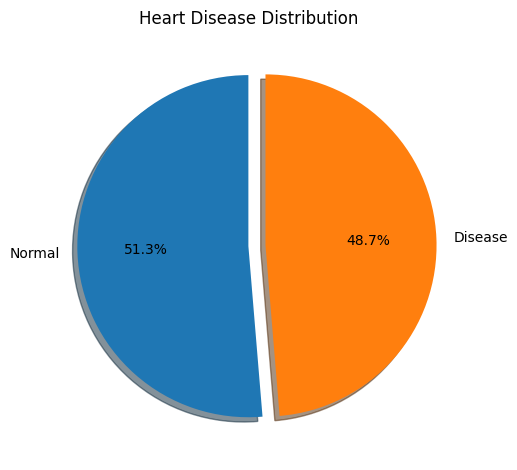

In [62]:
df["target"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[
    0, 0.1], shadow=True, labels=['Normal', 'Disease'], label='', title="Heart Disease Distribution")
plt.tight_layout()
plt.show()

In [63]:
heart_disease_distribution = df['target'].value_counts()
print(heart_disease_distribution)

target
1    526
0    499
Name: count, dtype: int64


Spliting the dataset into train and test data. It's 80-20 split

In [64]:
target_variable = "target"
X, y = df.drop(columns=target_variable), df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [65]:
target_variable = "target"
network = [(target_variable, x) for x in df.columns if x != target_variable]
naive_bayes = BayesianNetwork(network)

Installing a library used to create visual representation of Bayesian Network

In [66]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import pydot 
print(pydot.__version__)
print(dir(pydot))

3.0.3
['CLUSTER_ATTRIBUTES', 'Cluster', 'Common', 'DEFAULT_PROGRAMS', 'Dot', 'EDGE_ATTRIBUTES', 'Edge', 'Error', 'GRAPH_ATTRIBUTES', 'Graph', 'NODE_ATTRIBUTES', 'Node', 'OUTPUT_FORMATS', 'PydotException', 'Subgraph', '__author__', '__builtins__', '__cached__', '__doc__', '__file__', '__license__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_logger', '_vendor', 'any_needs_quotes', 'call_graphviz', 'copy', 'core', 'dot_keywords', 'dot_parser', 'errno', 'exceptions', 'frozendict', 'get_executable_extension', 'graph_from_adjacency_matrix', 'graph_from_dot_data', 'graph_from_dot_file', 'graph_from_edges', 'graph_from_incidence_matrix', 'id_needs_quotes', 'id_re_alpha_nums', 'id_re_alpha_nums_with_ports', 'id_re_with_port', 'is_anaconda', 'is_windows', 'logging', 'make_quoted', 'os', 'pydot', 'quote_attr_if_necessary', 'quote_id_if_necessary', 're', 're_dbl_quoted', 're_html', 're_numeric', 'subprocess', 'sys', 'tempfile']


Naive Bayes classifier used to build the structure of Bayesian Network.

In [68]:
dot_string = "digraph G {\n"

# Add edges between the nodes manually
for parent, child in naive_bayes.edges():  # This assumes you have a method to get edges
    dot_string += f'    "{parent}" -> "{child}";\n'

dot_string += "}"

# Create the pydot graph from the dot string
graph = pydot.graph_from_dot_data(dot_string)[0]

# Now you can render the graph as a PNG file
graph.write_png('bayesian_network1.png')

K-fold cross validation 

In [69]:
kfold = KFold(5, shuffle=True, random_state=42)

def bayesian_kfold(df, model, metric):
    score = []
    predictions = []
    for train, test in kfold.split(df):
        model.cpds = []
        model.fit(df.iloc[train, :], estimator=MaximumLikelihoodEstimator)
        y_pred = model.predict(df.drop(columns=target_variable, axis=1).iloc[test, :])
        score.append(
            metric(df[target_variable].iloc[test], y_pred[target_variable]))
        predictions.append(y_pred)
    return sum(score) / len(score), predictions[0]

In [70]:
roc_auc_value, _ = bayesian_kfold(df, naive_bayes, roc_auc_score)

100%|██████████| 156/156 [00:00<00:00, 2306.63it/s]


In [71]:
print(f"The roc_auc score for the naive bayesian network is {roc_auc_value:.2f}")

The roc_auc score for the naive bayesian network is 0.79


Hill Climbing Algorithm

In [72]:
scores = {} # Dictionary to store the roc_auc_score for each scoring method
networks = {} # Dictionary to store the network structure for each scoring method

for scoring in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    network = HillClimbSearch(df, use_cache=False).estimate(scoring_method=scoring)
    networks[scoring] = network    
    model = BayesianNetwork(network)
    scores[scoring], _ = bayesian_kfold(df, model, roc_auc_score)

100%|██████████| 156/156 [00:00<00:00, 897.42it/s]


The plot of ROC AUC curve of Hill Climbing Algorithm

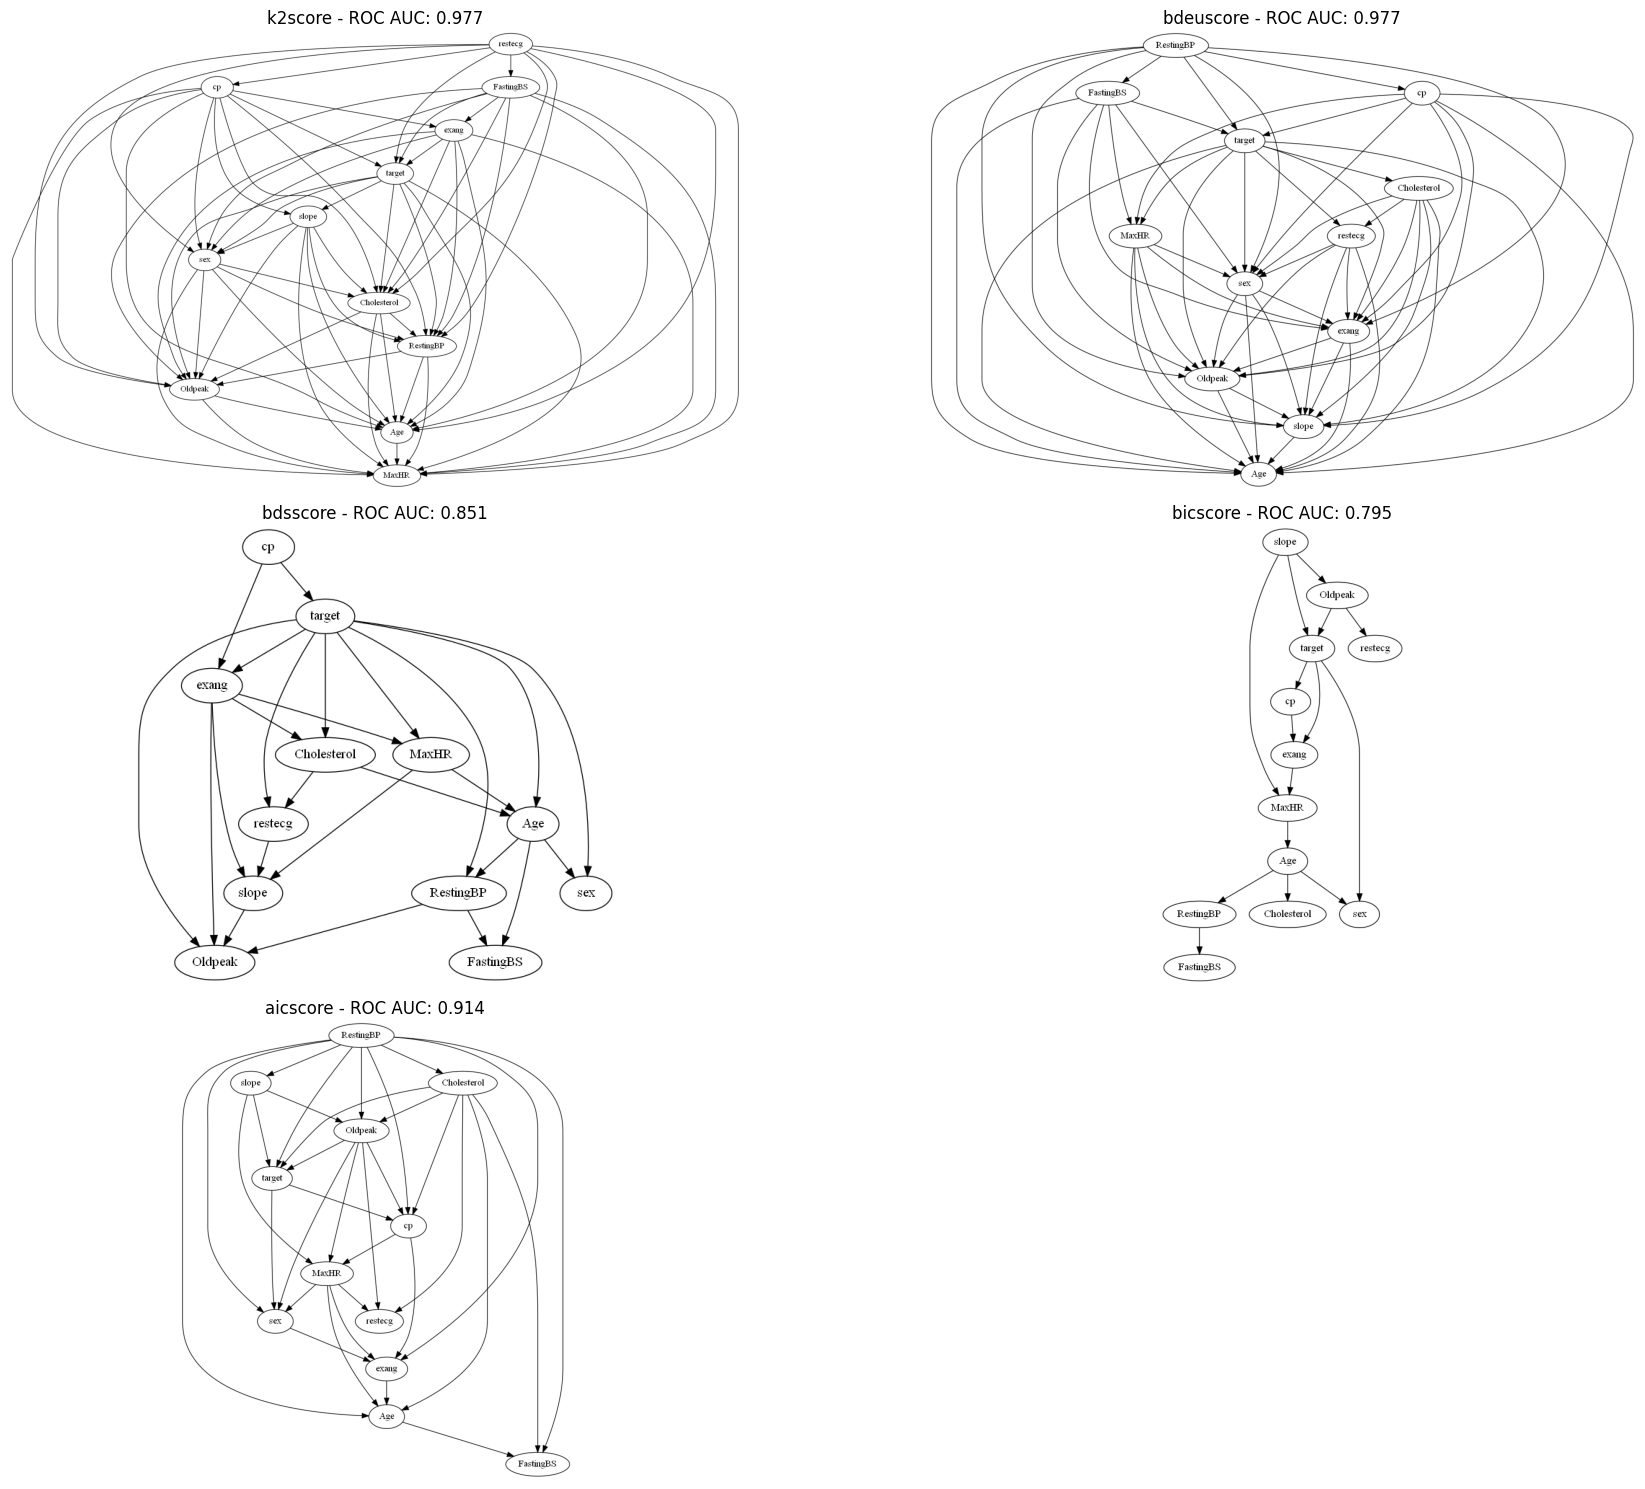

In [73]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO

ig = plt.figure(figsize=(20, 15))
i = 1

for scoring in networks:
    # Create DOT format string for the current network
    dot_string = "digraph BayesianNetwork {\n"
    for parent, child in networks[scoring].edges():
        dot_string += f'    "{parent}" -> "{child}";\n'
    dot_string += "}"

    # Generate the graph using Pydot
    graph = pydot.graph_from_dot_data(dot_string)[0]

    # Convert the graph into an image and display it with Matplotlib
    png_bytes = graph.create_png()
    image_stream = BytesIO(png_bytes)

    plt.subplot(3, 2, i)
    img = mpimg.imread(image_stream, format='png')
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{scoring} - ROC AUC: {scores[scoring]:.3f}")
    i += 1

plt.tight_layout()
plt.show()

In [74]:
pd.DataFrame(scores, index = ['ROC AUC'])

,k2score,bdeuscore,bdsscore,bicscore,aicscore
ROC AUC,0.976682,0.976709,0.851387,0.794603,0.914097


In [75]:
hc_unconst = HillClimbSearch(df, use_cache=False).estimate(scoring_method='bdeuscore')

  0%|          | 59/1000000 [00:27<128:26:22,  2.16it/s]


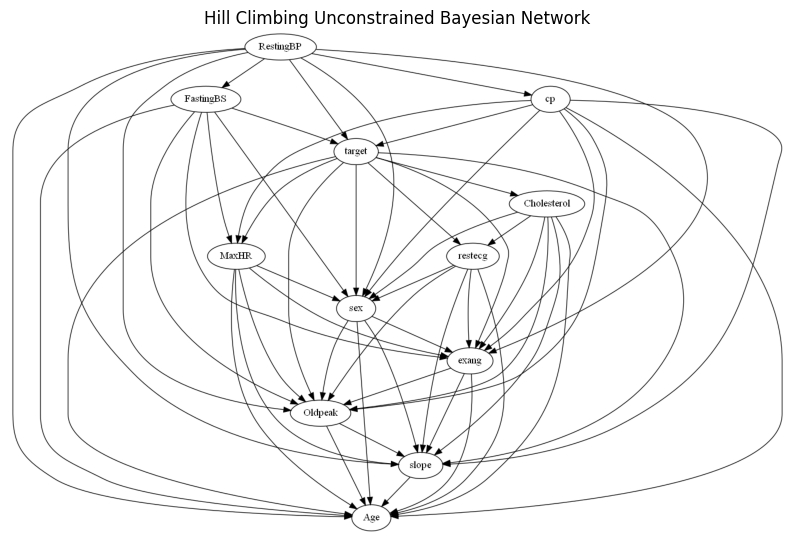

In [76]:
def networkx_to_pydot(graph):
    dot_string = "digraph G {\n"
    for parent, child in graph.edges():
        dot_string += f'    "{parent}" -> "{child}";\n'
    dot_string += "}"
    return pydot.graph_from_dot_data(dot_string)[0]

# Convert your graph (hc_unconst) to Pydot
pydot_graph = networkx_to_pydot(hc_unconst)

# Save the graph visualization as a PNG file
pydot_graph.write_png("hc_unconst_visualization.png")

# Display the saved PNG image
img = mpimg.imread("hc_unconst_visualization.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Hill Climbing Unconstrained Bayesian Network")
plt.show()

In [77]:
black_list = [(target_variable, 'Cholesterol'), 
              ('Oldpeak', target_variable),
              ('slope', target_variable),
              ('slope', 'MaxHR'),
              ('exang', 'Cholesterol'),
              ('slope', 'Oldpeak'),
              ('exang', 'restecg'),
              ('exang', 'cp')] + [(x, 'sex')for x in df.columns] + [(x, 'Age') for x in df.columns]

In [78]:
hc_const = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore', black_list=black_list)

  0%|          | 53/1000000 [00:20<105:35:02,  2.63it/s]


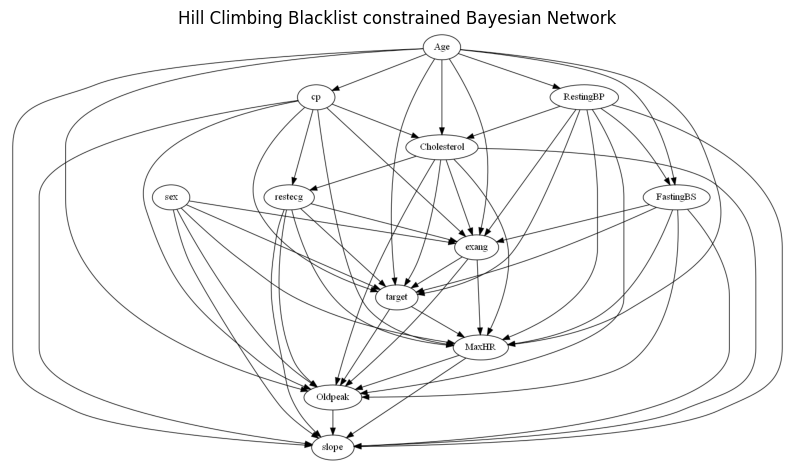

In [79]:
def networkx_to_pydot(graph):
    dot_string = "digraph G {\n"
    for parent, child in graph.edges():
        dot_string += f'    "{parent}" -> "{child}";\n'
    dot_string += "}"
    return pydot.graph_from_dot_data(dot_string)[0]

# Convert your graph (hc_const) to Pydot
pydot_graph = networkx_to_pydot(hc_const)

# Save the graph visualization as a PNG file
pydot_graph.write_png("hc_unconst_blacklist_visualization.png")

# Display the saved PNG image
img = mpimg.imread("hc_unconst_blacklist_visualization.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Hill Climbing Blacklist constrained Bayesian Network")
plt.show()

Manually added edges 

In [80]:
df_filtered = df[['sex', 'Cholesterol', 'Oldpeak', 'slope', 'restecg', 'RestingBP', 'FastingBS', 'Age', target_variable]]
hc_const = nx.DiGraph()
hc_const.add_edge('sex', 'Cholesterol')
hc_const.add_edge('Cholesterol', target_variable)
hc_const.add_edge('Oldpeak', 'slope')
hc_const.add_edge('restecg', target_variable)
hc_const.add_edge('RestingBP', target_variable)
hc_const.add_edge('Cholesterol', 'RestingBP')
hc_const.add_edge('FastingBS', target_variable)
hc_const.add_edge('Age', 'Cholesterol')

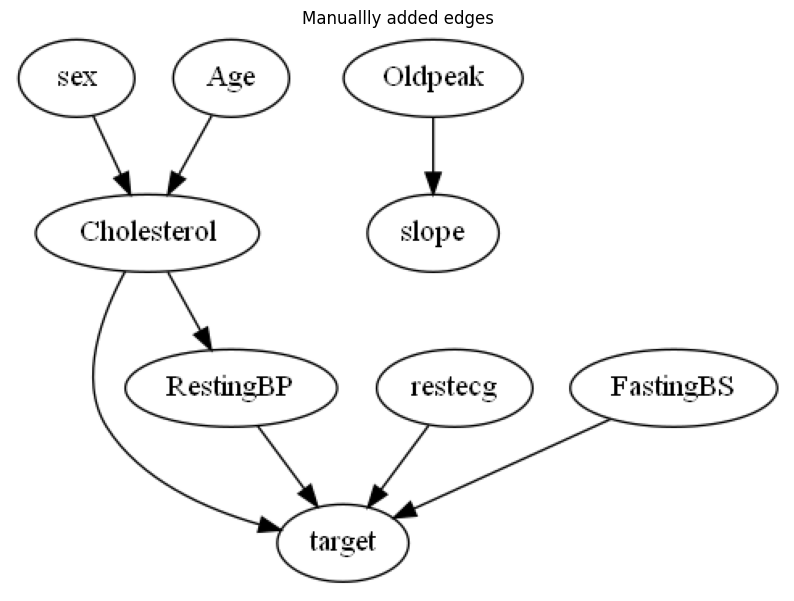

In [81]:
def networkx_to_pydot(graph):
    dot_string = "digraph G {\n"
    for parent, child in graph.edges():
        dot_string += f'    "{parent}" -> "{child}";\n'
    dot_string += "}"
    return pydot.graph_from_dot_data(dot_string)[0]

# Convert your graph (hc_const) to Pydot
pydot_graph = networkx_to_pydot(hc_const)

# Save the graph visualization as a PNG file
pydot_graph.write_png("manual_added_edges1.png")

# Display the saved PNG image
img = mpimg.imread("manual_added_edges1.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Manuallly added edges")
plt.show()

In [82]:
edges = list(hc_const.edges())
hc_const_model = BayesianNetwork(edges)

print(hc_const_model)

BayesianNetwork with 9 nodes and 8 edges


In [83]:
hc_const_model.fit(df_filtered, estimator=MaximumLikelihoodEstimator)

# Make predictions using the model
predictions = hc_const_model.predict(df_filtered.drop(columns=[target_variable]))

# Convert predictions to the format of the target variable
predicted_values = predictions[target_variable].values

# Evaluate accuracy
accuracy = accuracy_score(df_filtered[target_variable], predicted_values)
print(f"Accuracy: {accuracy}")

100%|██████████| 243/243 [00:00<00:00, 1997.37it/s]

Accuracy: 0.646829268292683


The ROC AUC of Manually added edges

ROC AUC: 0.6476641495919596


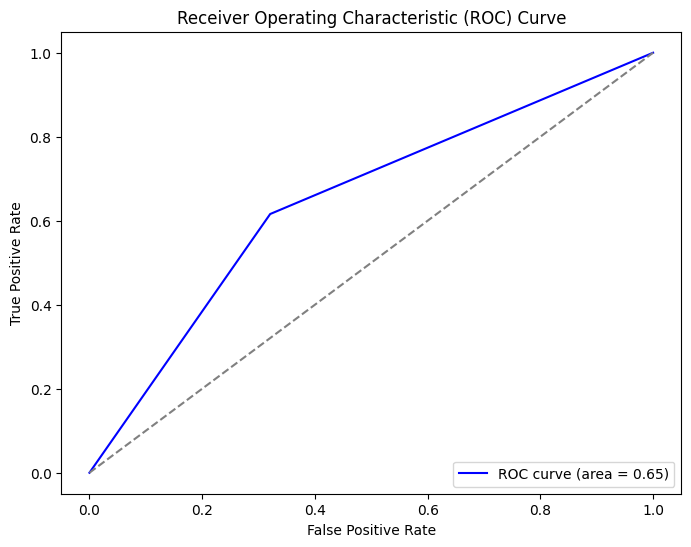

In [84]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(df_filtered[target_variable], predicted_values)
roc_auc = roc_auc_score(df_filtered[target_variable], predicted_values)
print(f"ROC AUC: {roc_auc}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [85]:
print(f'Accuarcy: {accuracy:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuarcy: 0.647
ROC AUC: 0.648


Domain Knowledge

In [86]:
domain_kg_model = BayesianNetwork([
    ('Age', 'Cholesterol'),
    ('Age', 'restecg'),
    ('Age', 'MaxHR'),
    ('Age', 'RestingBP'),
    ('Age', 'FastingBS'),
    ('Age', target_variable),
    ('sex', 'Cholesterol'),
    ('sex', 'MaxHR'),
    ('sex', 'exang'),
    ('sex', target_variable),
    ('restecg', target_variable),
    ('MaxHR', 'exang'),
    ('Cholesterol', target_variable),
    ('Cholesterol', 'RestingBP'),
    ('RestingBP', 'FastingBS'),
    ('FastingBS', target_variable),
    ('exang', target_variable),
    ('exang', 'Oldpeak'),
    ('exang', 'slope'),
    (target_variable, 'Oldpeak'),
    (target_variable, 'slope'),
    (target_variable, 'cp'),
    ('Oldpeak', 'slope'),
]
)

In [87]:
domain_kg_model.cpds = []
domain_kg_model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
domain_kg_model.get_cpds()
assert domain_kg_model.check_model()

In [88]:
accuracy, _ = bayesian_kfold(df, domain_kg_model, accuracy_score)
roc_auc, y_pred = bayesian_kfold(df, domain_kg_model, roc_auc_score)

100%|██████████| 156/156 [00:00<00:00, 1039.69it/s]


In [89]:
print(f'Accuarcy: {accuracy:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuarcy: 0.860
ROC AUC: 0.861


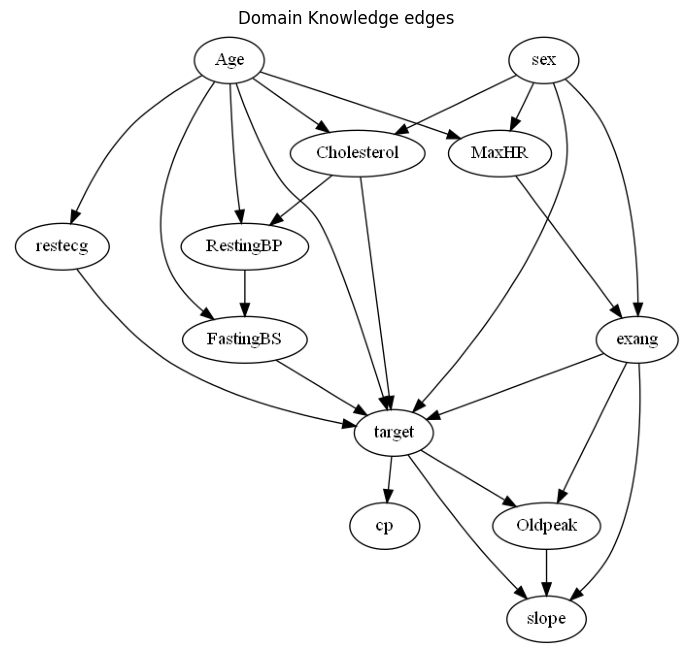

In [90]:
def networkx_to_pydot(graph):
    dot_string = "digraph G {\n"
    for parent, child in graph.edges():
        dot_string += f'    "{parent}" -> "{child}";\n'
    dot_string += "}"
    return pydot.graph_from_dot_data(dot_string)[0]

# Convert your graph (hc_const) to Pydot
pydot_graph = networkx_to_pydot(domain_kg_model)

# Save the graph visualization as a PNG file
pydot_graph.write_png("domain knowledge.png")

# Display the saved PNG image
img = mpimg.imread("domain knowledge.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Domain Knowledge edges")
plt.show()

Logistic Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
X = data.drop(columns=['target'])  # Drop 'target' column
y = data['target']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Evaluate model probabilities (for ROC curve, etc.)
y_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f"AUC Score: {auc_score:.2f}")